In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from utils.helpers.pandas_helpers import keep_levels, index_slice
from objects.signals.individual.momentum import Momentum
from objects.signals.individual.fair_value.pca import PCA
from objects.data_manipulation.backtester.position import Position
from objects.signals.combination.simple_combination import SignalSelector
from objects.signals.combination.ml_combination import MLSignalSelector
%load_ext autoreload
%autoreload 2


# STEP 1: Select Investment universe

In [2]:

investment_universe = [
    'BTC/USDC:USDC',
    'ETH/USDC:USDC',
    'XRP/USDC:USDC']

# Read prices
- We will start reading the prices updated hourly
- Keep open prices
- Subset --> Investment universe

In [3]:
df= pd.read_parquet('/Users/educontreras/PycharmProjects/crypto_signals/objects/retriever/daily_prices.parquet')
df.columns = df.columns.rename("field", level=0)
close_df = keep_levels(index_slice(df, field = 'open'), ['symbol'])

df_subset = close_df.loc[:, investment_universe]
returns_df = df_subset.pct_change().dropna(how = 'any')

In [4]:
all_windows = [6, 12, 24]
tstat_signal = Momentum.tstat(returns_df, windows = all_windows)
sma_signal = Momentum.sma(df_subset, windows = [6, 12, 24])
ema_signal = Momentum.ema(df_subset, windows = [6, 12, 26])

hma_signal = Momentum.ema(df_subset, windows = [6, 12, 24])
signal, macd = SignalSelector.macd(hma_signal, short_window=6, long_window=12, combination_window=9,  signal_level='signal', asset_level='symbol')
rsi_signal = Momentum.rsi(df_subset, windows = [6, 12, 24])

2024-12-29 08:51:26.657 | INFO     | objects.signals.individual.momentum:tstat:144 - Computing momentum tstat signal
2024-12-29 08:51:26.657 | INFO     | objects.signals.individual.momentum:tstat:147 - ASSET - BTC/USDC:USDC
2024-12-29 08:51:26.658 | INFO     | objects.signals.individual.momentum:tstat:149 - WINDOW - 6
2024-12-29 08:51:26.662 | INFO     | objects.signals.individual.momentum:tstat:149 - WINDOW - 12
2024-12-29 08:51:26.665 | INFO     | objects.signals.individual.momentum:tstat:149 - WINDOW - 24
2024-12-29 08:51:26.668 | INFO     | objects.signals.individual.momentum:tstat:147 - ASSET - ETH/USDC:USDC
2024-12-29 08:51:26.669 | INFO     | objects.signals.individual.momentum:tstat:149 - WINDOW - 6
2024-12-29 08:51:26.672 | INFO     | objects.signals.individual.momentum:tstat:149 - WINDOW - 12
2024-12-29 08:51:26.675 | INFO     | objects.signals.individual.momentum:tstat:149 - WINDOW - 24
2024-12-29 08:51:26.679 | INFO     | objects.signals.individual.momentum:tstat:147 - ASSE

<Axes: xlabel='timestamp'>

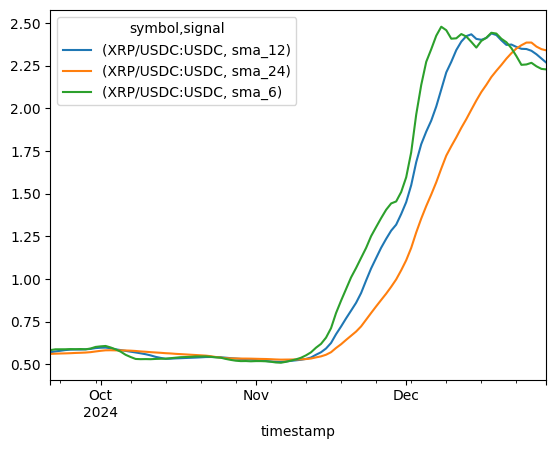

In [5]:
index_slice(sma_signal, symbol = 'XRP/USDC:USDC').tail(100).plot()

In [146]:
a = pd.concat([macd,signal,  df_subset], axis = 1).dropna(how = 'any')
a.columns = ['ETH_MACD', 'XRP_MACD', 'ETH_Signal','XRP_Signal', 'ETH',]
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd


# Crear la figura con subgráficos
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05)

# Agregar la señal MACD al primer subplot
fig.add_trace(
    go.Scatter(x=a.index, y=a['Signal'], mode='lines', name='Signal', line=dict(color='blue')),
    row=1, col=1
)

# Agregar el precio al segundo subplot
fig.add_trace(
    go.Scatter(x=a.index, y=a['Price'], mode='lines', name='Precio', line=dict(color='green')),
    row=2, col=1
)

# Personalizar diseño
fig.update_layout(
    height=600,  # Altura total del gráfico
    title_text="Signal and Price",
    showlegend=True,
    xaxis_title="Índice",
    yaxis_title="Valor",
    template="plotly_white"  # Tema blanco
)

# Mostrar el gráfico
fig.show()


ValueError: Length mismatch: Expected axis has 9 elements, new values have 5 elements

<Axes: xlabel='timestamp'>

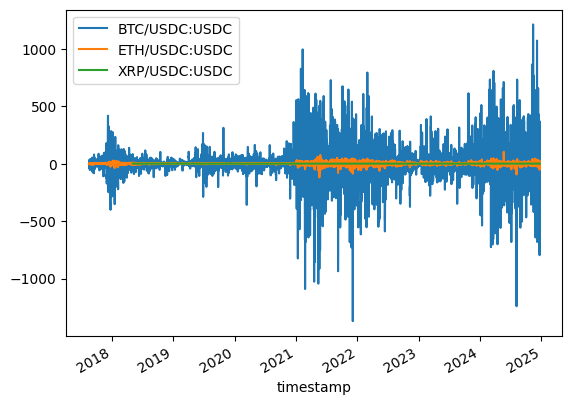

In [147]:
signal.plot()

In [161]:

long_entry_level = 0  # Entrar cuando la señal sea mayor que 0
long_exit_level = 0  # Salir si la señal vuelve a 0 o menos
weakening_threshold = 0.5  # Salir si disminuye más de un 10% en un periodo
short_entry_level = -np.inf  # No usar señales short
short_exit_level = 0  # No usar señales short

# Generar señales
positions = Position.trend_following(
    signal,
    long_entry_level=long_entry_level,
    long_exit_level=long_exit_level,
    short_entry_level=short_entry_level,  # Desactivado
    short_exit_level=short_exit_level,   # Desactivado
    weakening_threshold=weakening_threshold,
    number_days_confirmation=0,
    max_holding_period=None
)


<Axes: xlabel='timestamp'>

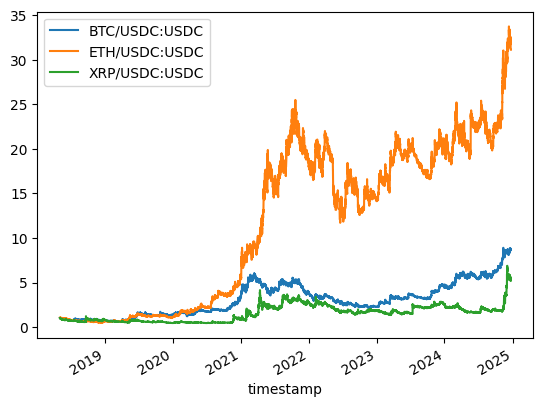

In [163]:

((positions.shift(1)* returns_df) + 1).cumprod().plot()

In [142]:
returns_df.dropna().align(positions, join = 'inner')[1]

symbol,BTC/USDC:USDC,ETH/USDC:USDC,XRP/USDC:USDC
timestamp,,,
2018-05-04 09:00:00,0.010365,0.026656,0.846000
2018-05-04 10:00:00,-0.003762,-0.005957,-0.022763
2018-05-04 11:00:00,-0.005188,-0.005931,-0.000787
2018-05-04 12:00:00,0.005080,0.007636,0.016288
2018-05-04 13:00:00,-0.004338,-0.005559,-0.016322
...,...,...,...
2024-12-22 12:00:00,0.000951,0.000527,-0.006943
2024-12-22 13:00:00,-0.001171,-0.001751,-0.001372
2024-12-22 14:00:00,-0.000120,-0.001227,0.003102


In [ ]:
ml_signal = MLSignalSelector.random_forest(signal,returns_df,window_level='period', asset_level = 'symbol')

<Axes: xlabel='timestamp'>

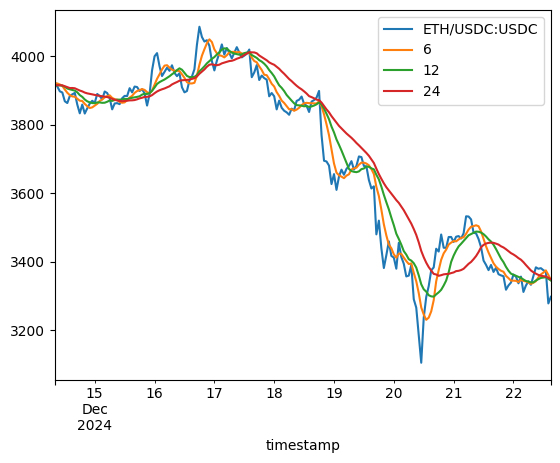

In [58]:
signal_to_plot = keep_levels(index_slice(sma_signal, symbol = 'ETH/USDC:USDC'), ['period'])
pd.merge(df_subset.loc[:, ['ETH/USDC:USDC']], signal_to_plot, left_index = True, right_index=True).tail(200).plot()

<Axes: xlabel='timestamp'>

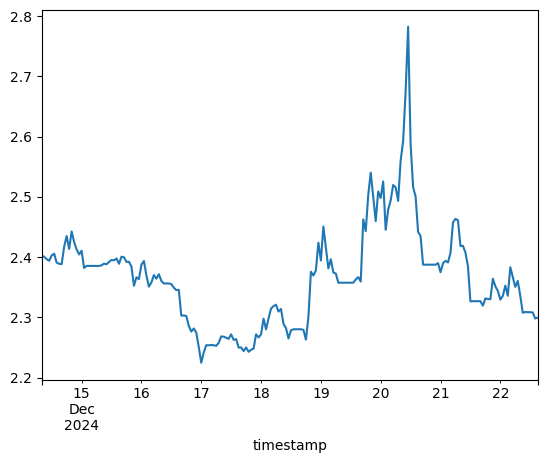

In [60]:
strategy_returns_all_assets.mean(axis = 1).tail(200).plot()

[autoreload of __main__ failed: Traceback (most recent call last):
  File "/Users/educontreras/PycharmProjects/crypto_signals/venv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/educontreras/PycharmProjects/crypto_signals/venv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/importlib/__init__.py", line 148, in reload
    raise ImportError(msg.format(name), name=name)
ImportError: module objects.data_manipulation.normalizer not in sys.modules
]
2024-12-22 19:25:35.836 | INFO     | objects.data_manipulation.normalizer:compute_z_scores:18 - Starting Z-Score computation
2024-12-22 19:25:35.836 | INFO     | objects.data_manipulation.normalizer:compute_z_scores:22 - Computing Z-Score for window size 100
2024-12-22 19:25:35.847 | INFO     | objects.data_mani

<Axes: xlabel='period,symbol'>

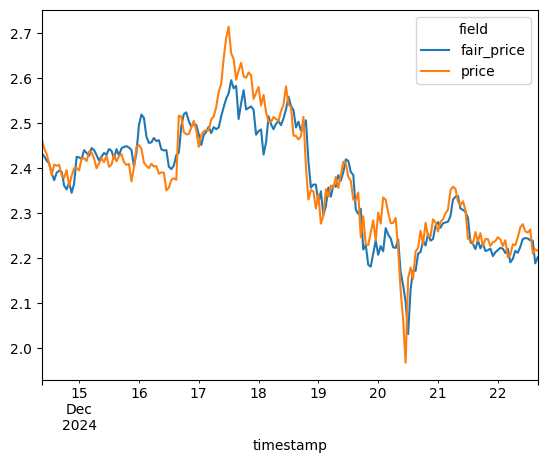

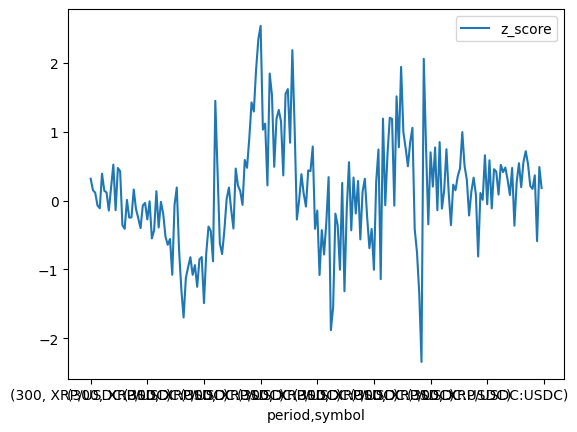

In [83]:
from objects.data_manipulation.normalizer import Normalizer
fv_df = keep_levels(index_slice(pca_df, symbol = 'XRP/USDC:USDC', period = 100, field = ['fair_price', 'price']), ['field']).dropna()
diff_df = keep_levels(index_slice(pca_df, period = 100, field = ['difference']), ['symbol']).dropna()
z_df = Normalizer.compute_z_scores(diff_df, windows = [100, 200, 300])
fv_df.tail(200).plot()
z_df.tail(200).plot()

In [80]:
z_df

z_score
period symbol                 
100    ADA/USDC:USDC       NaN
       ADA/USDC:USDC       NaN
       ADA/USDC:USDC       NaN
       ADA/USDC:USDC       NaN
       ADA/USDC:USDC       NaN
...                        ...
300    XRP/USDC:USDC  0.170170
       XRP/USDC:USDC  0.367424
       XRP/USDC:USDC -0.589163
       XRP/USDC:USDC  0.488605
       XRP/USDC:USDC  0.181801

[572205 rows x 1 columns]